# Figure 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def EFmod(nyr,a):
    Fcal = np.zeros((nyr,nyr))
    time = np.arange(nyr+1)
    F_0 = a[4]*a[13]*a[0]*time
    for j in [1,2,3]:
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in np.arange(nyr):
        Fcal[i,0]=F_0[i+1]-F_0[i]
    for j in np.arange(nyr):
        Fcal[j:nyr,j]=Fcal[0:nyr-j,0]
    return Fcal


In [3]:
# pro Smith_etal_fig1

# first set up AR5 model parameters, using syntax of FaIR but units of GtCO2, not GtC
ny2=200
tim2=np.arange(ny2)+1

m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
m_air=28.97*10**-3  # AR5 official molar mass of air
m_car=12.01*10**-3  # AR5 official molar mass of carbon
m_co2=44.01*10**-3  # AR5 official molar mass of CO2
m_ch4=16.043*10**-3 # AR5 official molar mass of air

scl=1*10**3
a_ar5=np.zeros(20)


# Set to AR5 Values for CO2
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863]
a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)# old value = 0.471 ppm/GtC # convert GtCO2 to ppm
a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]
a_ar5[10:12] = [0.631*0.7,0.429*0.7] #AR5 sensitivity coeffs
a_ar5[13] = 1.37e-2 # rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]
a_ar5[18:21] = 0

# Set to AR5 Values for CH4
a_ch4=a_ar5.copy()
a_ch4[0:4]=[0,1.0,0,0]
a_ch4[4]=1.e12*1.e9/m_ch4/(m_atm/m_air) # convert GtCH4 to ppb
a_ch4[5:9]=[1,12.4,1,1]
a_ch4[13]=1.65*3.6324360e-4 # RE W/m2/ppb

In [4]:
# set up an array for AGWP values
AR5_AGWP = np.zeros([200,20])
# compute standard AGWP of CO2 using AR5 formulae
AR5_AGWP[:,0] = a_ar5[4]*a_ar5[13]*a_ar5[0]*tim2
loop_range = np.arange(3)+1
for j in loop_range:
    AR5_AGWP[:,0] = AR5_AGWP[:,0]+a_ar5[4]*a_ar5[13]*a_ar5[j]*a_ar5[j+5]*(1-np.exp(-tim2/a_ar5[j+5]))
    
# compute standard AGWP of CH4 using AR5 formulae
AR5_AGWP[:,1] = a_ch4[4]*a_ch4[13]*a_ch4[1]*a_ch4[6]*(1-np.exp(-tim2/a_ch4[6]))

# Time Horizon
H=100
# values of s to use
s=[0.25,0.143,0.4]
g=[]
r=[]
for i in [0,1,2]:
    g.append((1-np.exp(-s[i]/(1-s[i])))/s[i])
    r.append(s[i]/(1-s[i])/H)
print(s,g,r)

GWP_H = AR5_AGWP[H,1]/AR5_AGWP[H,0]

[0.25, 0.143, 0.4] [1.133874757704843, 1.0747054560035358, 1.2164572024185198] [0.003333333333333333, 0.0016686114352392064, 0.006666666666666667]


In [14]:
c2 = GWP_H*H*g[0]*(1-s[0])/20
c1 = c2 + GWP_H*g[0]*s[0]
print('GWP* coefficients: ' + str(c1) + '  ' + str(c2) + '  ' + str(c1-c2))
print('GWP*/GWP coefficients: ' + str(c1/GWP_H) + '  ' + str(c2/GWP_H) + '  ' + str((c1-c2)/GWP_H))
# Compute total methane equivalent to 1000 GtCO2 under GWP*:
print('Total methane equivalent to 1000 GtCO2 under GWP*:' + str((1000/c1)/(1-(c2/c1))))

# compute variations on AGWP for CO2 based on exponential approximation
for i in [0,1,2]:
    AR5_AGWP[:,2+i]=AR5_AGWP[H,0]*(1-np.exp(-tim2*s[i]/(H*(1-s[i]))))/s[i]/g[i]

GWP* coefficients: 127.83486719643592  119.84518799665868  7.9896791997772425
GWP*/GWP coefficients: 4.535499030819371  4.25203034139316  0.2834686894262106
Total methane equivalent to 1000 GtCO2 under GWP*:125.16147081698604


In [6]:
# compute operators to convert emissions to forcing for CO2 and CH4
Fco2 = EFmod(ny2,a_ar5)
Fch4 = EFmod(ny2,a_ch4)

# create 1 GtCH4 constant emission
E5c=np.zeros(ny2)
E5c[:]=1/GWP_H 
# Compute forcing response
F5c=np.matmul(Fco2,E5c)#E5c

# Calculate CO2 warming-equivalent to 1 GtCO2-e/year constant methane emission
E5cs=np.zeros(ny2)
E5cs[0:19]=c1/GWP_H
E5cs[20:ny2-1]=(c1-c2)/GWP_H
# Compute forcing and temperature response
F5cs=np.matmul(Fco2,E5cs)#E5cs

# Compute old (2018) vintage GWP*
c0=GWP_H*H/20
E5cs18=E5cs*0
E5cs18[0:19]=c0/GWP_H
E5cs18[20:ny2-1]=0
F5cs18=np.matmul(Fco2,E5cs18)#E5cs18

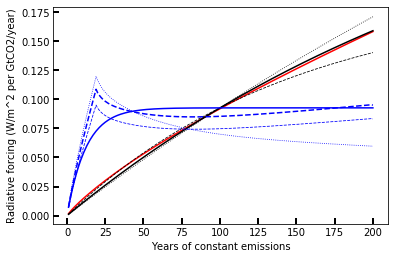

In [13]:
# Plotting
t = tim2

fig, ax = plt.subplots()

ax.plot(t,AR5_AGWP[:,0], color='red') # Red one

ax.plot(t,AR5_AGWP[:,2], color='black') # Solid Black
ax.plot(t,AR5_AGWP[:,3], color='black',linestyle = 'dotted',linewidth=0.8) # Dotted Black
ax.plot(t,AR5_AGWP[:,4], color='black',linestyle = 'dashed',linewidth=0.8) # Dashed Black

ax.plot(t,AR5_AGWP[:,1]/GWP_H, color='blue') # Solid Blue
ax.plot(t,F5cs,color='blue',linestyle = 'dashed')
ax.plot(t,F5cs*112/128,color='blue',linestyle = 'dashed',linewidth=0.8)
ax.plot(t,F5cs18,color='blue',linestyle = 'dotted',linewidth=0.8)

ax.set(xlabel='Years of constant emissions', ylabel='Radiative forcing (W/m^2 per GtCO2/year)')
ax.tick_params(direction='in', length=6, width=2, grid_alpha=0.1,which='both')

plt.savefig('Figure_1.jpg',dpi=500, bbox_inches = "tight")

# Figure 2. 

In [2]:
from fair.forward import fair_scm
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path[0]

species = 'CH4'

In [13]:
forcing=rcp3pd.Forcing.forcing
forcing26=rcp3pd.Forcing.forcing
forcing45=rcp45.Forcing.forcing
forcing6=rcp6.Forcing.forcing
forcing85=rcp85.Forcing.forcing


noco2=np.zeros(shape=forcing[:,9].shape, dtype=float)
noco226=np.zeros(shape=forcing[:,9].shape, dtype=float)
noco245=np.zeros(shape=forcing[:,9].shape, dtype=float)
noco26=np.zeros(shape=forcing[:,9].shape, dtype=float)
noco285=np.zeros(shape=forcing[:,9].shape, dtype=float)

#year is forcing[:,0] 
#methane forcing is forcing[:,9] 
#aer forcing is forcing[:,41] 
#here use zero co2 emissions and methane RF from RCP 2.6 MULTIPLIED BY 1.65 FOR O3 AND SWV
C_ch4,F_ch4,T_ch4 = fair_scm(fossilCH4_frac=0.,useMultigas=False,emissions=noco2,other_rf=forcing[:,9]*1.65)
C_ch426,F_ch426,T_ch426 = fair_scm(fossilCH4_frac=0.,useMultigas=False,emissions=noco226,other_rf=forcing26[:,9]*1.65)
C_ch445,F_ch445,T_ch445 = fair_scm(fossilCH4_frac=0.,useMultigas=False,emissions=noco245,other_rf=forcing45[:,9]*1.65)
C_ch46,F_ch46,T_ch46 = fair_scm(fossilCH4_frac=0.,useMultigas=False,emissions=noco26,other_rf=forcing6[:,9]*1.65)
C_ch485,F_ch485,T_ch485 = fair_scm(fossilCH4_frac=0.,useMultigas=False,emissions=noco285,other_rf=forcing85[:,9]*1.65)

#read in data
data = pd.read_csv('RCPdata/RCP3PD_EMISSIONS.csv', sep = ',',skiprows=36,index_col=0)
data26 = pd.read_csv('RCPdata/RCP3PD_EMISSIONS.csv', sep = ',',skiprows=36,index_col=0)
data45 = pd.read_csv('RCPdata/RCP45_EMISSIONS.csv', sep = ',',skiprows=36,index_col=0)
data6 = pd.read_csv('RCPdata/RCP6_EMISSIONS.csv', sep = ',',skiprows=36,index_col=0)
data85 = pd.read_csv('RCPdata/RCP85_EMISSIONS.csv', sep = ',',skiprows=36,index_col=0)


In [21]:
# GWP* Parameters
# Updated
b0s=0.75*1.13
a0s=0.25*1.13
# Cain 2019 Parameters
b0=0.75
a0=0.25
delt = 20

201

In [16]:
#CELLS TO SAVE IN SHARABLE CODE
#AR5 values of metrics without cc fb 
GWP100_CH4=28.
GWP20_CH4=84. 

GWP100_N2O=265.
GWP20_N2O=264.

In [17]:
#methane is read in in units of MtCH4/yr
ch4eq=GWP100_CH4*0.001*data['CH4']  #units GtCO2 
ch4eq26=GWP100_CH4*0.001*data26['CH4']  #units GtCO2 
ch4eq45=GWP100_CH4*0.001*data45['CH4']  #units GtCO2 
ch4eq6=GWP100_CH4*0.001*data6['CH4']  #units GtCO2 
ch4eq85=GWP100_CH4*0.001*data85['CH4']  #units GtCO2 

#AR5 table 8.SM.14 says uncertainty on CH4 GWP100 is +/-39% of the stated value 

In [23]:
#CELLS TO SAVE IN SHARABLE CODE
#### function to calc GWP* for a gas
#### eventually, put this in its own file and import it to tidy things up here

def convert_gwpstar(emis1,emis0,gwp100,verbose=False):
    #emis1 is the emission list you wish to convert 
    #emis0 is the emission list for 20 years ago
    #gwp100 is the gwp value to use. 
    
    if verbose == True:
        print ('convert ',emis1, 'to co2e*')
    if verbose == True:
        print ('ch4gwp100 used is ',gwp100, 'and Delta t is ',delt)
        print (np.subtract(emis1,emis0) ) * gwp100 * 100. / float(delt) 
    return (np.subtract(emis1,emis0) )* gwp100 * 100. / float(delt)



In [24]:

ch4data=data[species].iloc[delt:]*0.001   
ch4data0=data[species].iloc[0:-delt]*0.001
gwpstardata=convert_gwpstar(ch4data,ch4data0,GWP100_CH4,verbose=False)
gwpstardata_lo=convert_gwpstar(ch4data,ch4data0,GWP100_CH4*0.61,verbose=False)
gwpstardata_hi=convert_gwpstar(ch4data,ch4data0,GWP100_CH4*1.39,verbose=False)


ch4data26=data26[species].iloc[delt:]*0.001   
ch4data026=data26[species].iloc[0:-delt]*0.001
gwpstardata26=convert_gwpstar(ch4data26,ch4data026,GWP100_CH4,verbose=False)

ch4data45=data45[species].iloc[delt:]*0.001   
ch4data045=data45[species].iloc[0:-delt]*0.001
gwpstardata45=convert_gwpstar(ch4data45,ch4data045,GWP100_CH4,verbose=False)

ch4data6=data6[species].iloc[delt:]*0.001   
ch4data06=data6[species].iloc[0:-delt]*0.001
gwpstardata6=convert_gwpstar(ch4data6,ch4data06,GWP100_CH4,verbose=False)

ch4data85=data85[species].iloc[delt:]*0.001   
ch4data085=data85[species].iloc[0:-delt]*0.001
gwpstardata85=convert_gwpstar(ch4data85,ch4data085,GWP100_CH4,verbose=False)

In [25]:
#HERE CHOOSE TIME RANGE FOR NEXT CELLS/PLOTS
#1900 to 2100:
st=135
en=336
en-st

201

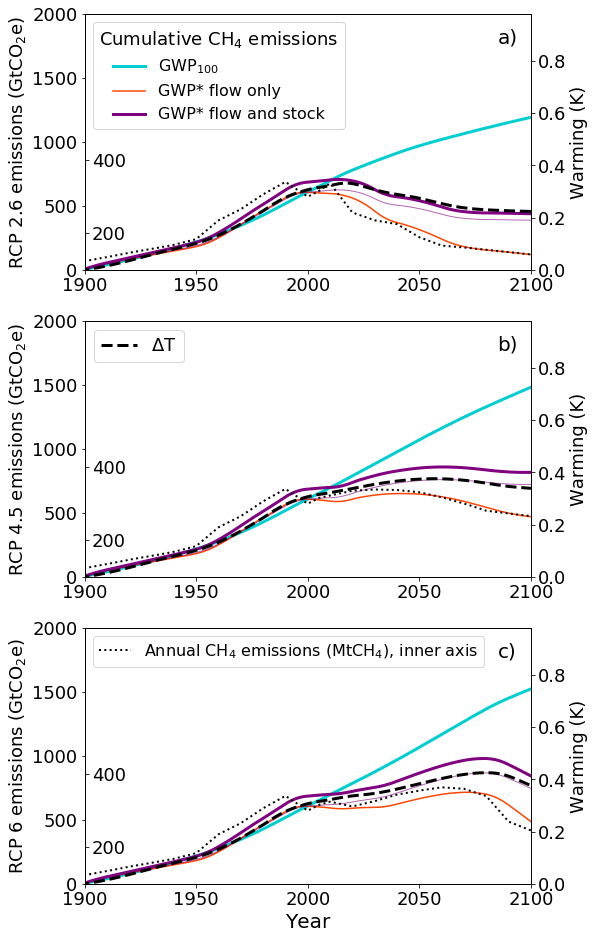

In [27]:
#1TtCO2=1000GtCO2=0.3C

plt.rcParams['font.size'] = 18

plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
#gwp100
fig, (axgwpc,axgwpc45,axgwpc6) = plt.subplots(nrows=3,ncols=1)
fig.subplots_adjust(wspace = 0.25)


#rcp2.6
axgwpc.plot(np.cumsum(ch4eq[st:en]),color='darkturquoise',linewidth=3.0)
axgwpc.plot(np.cumsum(gwpstardata[st-delt:en-delt]),color='orangered')
axgwpc.plot(np.cumsum((a0s*ch4eq[st:en])+(b0s*gwpstardata[st-delt:en-delt])),color='purple',linewidth=3.0)
axgwpc.plot(np.cumsum((a0*ch4eq[st:en])+(b0*gwpstardata[st-delt:en-delt])),color='purple',linewidth=1.0,alpha=0.6)
axgwpc2=axgwpc.twinx()
axgwpc2.plot(forcing[:,0],T_ch426-T_ch426[st],color='black',linestyle='--',linewidth=3)
axgwpc2.set_ylim(0,.49*2.)

axgwpc3=axgwpc.twinx()
axgwpc3.spines["right"].set_position(("axes", 0))
axgwpc3.set_ylim(100,800)
axgwpc3.plot(data26['CH4'],color='k',linewidth=2.,linestyle=':')
axgwpc3.yaxis.set_ticks(np.arange(200, 600, 200))


axgwpc.set_xlim(1900,2100)
axgwpc.set_ylim(0,2000)
axgwpc.legend(['GWP$_{100}$','GWP* flow only','GWP* flow and stock'],fontsize=16,title='Cumulative CH$_4$ emissions', loc='upper left')#[0.1,0.57])
axgwpc.xaxis.set_ticks(np.arange(1900, 2150, 50))
axgwpc.set_ylabel('RCP 2.6 emissions (GtCO$_2$e)',fontsize=18)
axgwpc2.set_ylabel('Warming (K)',fontsize=18)

#rcp45
axgwpc45.plot(np.cumsum(ch4eq45[st:en]),color='darkturquoise',linewidth=3.0)
axgwpc45.plot(np.cumsum(gwpstardata45[st-delt:en-delt]),color='orangered')
axgwpc45.plot(np.cumsum((a0s*ch4eq45[st:en])+(b0s*gwpstardata45[st-delt:en-delt])),color='purple',linewidth=3.0)
axgwpc45.plot(np.cumsum((a0*ch4eq45[st:en])+(b0*gwpstardata45[st-delt:en-delt])),color='purple',linewidth=1.0,alpha=0.6)
axgwpc452=axgwpc45.twinx()
axgwpc452.plot(forcing[:,0],T_ch445-T_ch445[st],color='black',linestyle='--',linewidth=3)
axgwpc452.set_ylim(0,.49*2.)

axgwpc45.set_xlim(1900,2100)
axgwpc45.set_ylim(0,2000)

axgwpc45.xaxis.set_ticks(np.arange(1900, 2150, 50))

axgwpc45.set_ylabel('RCP 4.5 emissions (GtCO$_2$e)',fontsize=18)
axgwpc452.set_ylabel('Warming (K)',fontsize=18)
axgwpc452.legend(['$\Delta$T'],loc='upper left')

#plt.tight_layout()
axgwpc453=axgwpc45.twinx()
axgwpc453.spines["right"].set_position(("axes", 0))
axgwpc453.set_ylim(100,800)
axgwpc453.plot(data45['CH4'],color='k',linewidth=2.,linestyle=':')
axgwpc453.yaxis.set_ticks(np.arange(200, 600, 200))



#rcp6
axgwpc6.plot(np.cumsum(ch4eq6[st:en]),color='darkturquoise',linewidth=3.0)
axgwpc6.plot(np.cumsum(gwpstardata6[st-delt:en-delt]),color='orangered')
axgwpc6.plot(np.cumsum((a0s*ch4eq6[st:en])+(b0s*gwpstardata6[st-delt:en-delt])),color='purple',linewidth=3.0)
axgwpc6.plot(np.cumsum((a0*ch4eq6[st:en])+(b0*gwpstardata6[st-delt:en-delt])),color='purple',linewidth=1.0,alpha=0.6)
axgwpc62=axgwpc6.twinx()
axgwpc62.plot(forcing[:,0],T_ch46-T_ch46[st],color='black',linestyle='--',linewidth=3)
axgwpc62.set_ylim(0,.49*2.)

axgwpc6.set_xlim(1900,2100)
axgwpc6.set_ylim(0,2000)

axgwpc6.xaxis.set_ticks(np.arange(1900, 2150, 50))
axgwpc6.set_ylabel('RCP 6 emissions (GtCO$_2$e)',fontsize=18)
axgwpc62.set_ylabel('Warming (K)',fontsize=18)
axgwpc6.set_xlabel('Year',fontsize=20)

axgwpc63=axgwpc6.twinx()
axgwpc63.spines["right"].set_position(("axes", 0))
axgwpc63.set_ylim(100,800)
axgwpc63.plot(data6['CH4'],color='k',linewidth=2.,linestyle=':')
axgwpc63.yaxis.set_ticks(np.arange(200, 600, 200))
axgwpc63.legend(['Annual CH$_4$ emissions (MtCH$_4$), inner axis'],fontsize=16,loc='upper left')

fig.set_size_inches(8,16)

plt.text(2085, 2400, 'a)', fontsize=20,color='black')
plt.text(2085, 1560, 'b)', fontsize=20,color='black')
plt.text(2085, 720, 'c)', fontsize=20,color='black')
plt.savefig('Figure_2.jpg',dpi=500, bbox_inches = "tight")
